

# Path and skimming

In this example, we show how to perform path computation and network skimming
for the Sioux Falls example model.


In [1]:
# Imports
from uuid import uuid4
from tempfile import gettempdir
from os.path import join
from aequilibrae.utils.create_example import create_example

# We create the example project inside our temp folder
fldr = join(gettempdir(), uuid4().hex)

project = create_example(fldr)

In [2]:
import logging
import sys

# We the project opens, we can tell the logger to direct all messages to the terminal as well
logger = project.logger
stdout_handler = logging.StreamHandler(sys.stdout)
formatter = logging.Formatter("%(asctime)s;%(levelname)s ; %(message)s")
stdout_handler.setFormatter(formatter)
logger.addHandler(stdout_handler)

## Path Computation



In [3]:
from aequilibrae.paths import PathResults

We build all graphs



In [4]:
project.network.build_graphs()
# We get warnings that several fields in the project are filled with NaNs. 
# This is true, but we won't use those fields.

2023-05-03 15:49:32,700;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations
2023-05-03 15:49:32,740;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations
2023-05-03 15:49:32,760;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations
2023-05-03 15:49:32,779;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations
2023-05-03 15:49:32,798;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations
2023-05-03 15:49:32,817;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations


We grab the graph for cars



In [5]:
graph = project.network.graphs["c"]

# we also see what graphs are available
# project.network.graphs.keys()

# let's say we want to minimize the distance
graph.set_graph("distance")

# And will skim time and distance while we are at it
graph.set_skimming(["free_flow_time", "distance"])

# And we will allow paths to be computed going through other centroids/centroid connectors
# required for the Sioux Falls network, as all nodes are centroids
# BE CAREFUL WITH THIS SETTING
graph.set_blocked_centroid_flows(False)

Let's instantiate a path results object and prepare it to work with the graph



In [6]:
res = PathResults()
res.prepare(graph)

# compute a path from node 8 to 13
res.compute_path(8, 4)

In [7]:
# We can get the sequence of nodes we traverse
res.path_nodes

array([8, 9, 5, 4])

In [8]:
# We can get the link sequence we traverse
res.path

array([21, 23, 11])

In [9]:
# We can get the mileposts for our sequence of nodes
res.milepost

array([   0.        , 2213.32449172, 3927.86012613, 5188.91313598])

In [10]:
# If we want to compute the path for a different destination and the same origin, we can just do this
# It is way faster when you have large networks
res.update_trace(13)

In [11]:
res.path_nodes

array([ 8,  9, 10, 15, 22, 21, 24, 13])

If you want to show the path in Python
We do NOT recommend this, though....  It is very slow for real networks



In [12]:
import matplotlib.pyplot as plt
from shapely.ops import linemerge

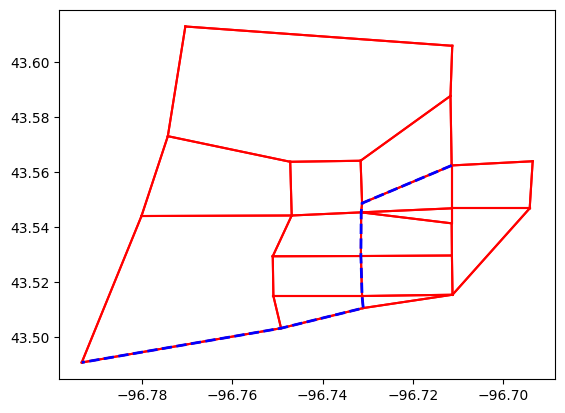

In [13]:
links = project.network.links

# We plot the entire network
curr = project.conn.cursor()
curr.execute("Select link_id from links;")

for lid in curr.fetchall():
    geo = links.get(lid[0]).geometry
    plt.plot(*geo.xy, color="red")

path_geometry = linemerge(links.get(lid).geometry for lid in res.path)
plt.plot(*path_geometry.xy, color="blue", linestyle="dashed", linewidth=2)
plt.show()

## Now to skimming



In [14]:
from aequilibrae.paths import NetworkSkimming

But let's say we only want a skim matrix for nodes 1, 3, 6 & 8



In [15]:
import numpy as np

graph.prepare_graph(np.array([1, 3, 6, 8]))

2023-05-03 15:49:52,997;WARNING ; Field(s) name, lanes has(ve) at least one NaN value. Check your computations


In [16]:
# And run the skimming
skm = NetworkSkimming(graph)
skm.execute()

The result is an AequilibraEMatrix object



In [17]:
skims = skm.results.skims

# Which we can manipulate directly from its temp file, if we wish
skims.matrices

array([[[0.00000000e+00, 0.00000000e+00],
        [6.00000000e+00, 4.84008627e+03],
        [9.00000000e+00, 6.46536178e+03],
        [1.30000000e+01, 8.88889720e+03]],

       [[6.00000000e+00, 4.84008627e+03],
        [0.00000000e+00, 0.00000000e+00],
        [9.00000000e+00, 6.73286110e+03],
        [2.10000000e+01, 6.82126560e+03]],

       [[9.00000000e+00, 4.97310839e+03],
        [1.00000000e+01, 8.30423993e+03],
        [0.00000000e+00, 0.00000000e+00],
        [4.00000000e+00, 2.42353542e+03]],

       [[1.10000000e+01, 6.23416140e+03],
        [2.00000000e+01, 8.12432422e+03],
        [2.00000000e+00, 1.26105301e+03],
        [0.00000000e+00, 0.00000000e+00]]])

In [18]:
# Or access each matrix
skims.free_flow_time

array([[ 0.,  6.,  9., 13.],
       [ 6.,  0.,  9., 21.],
       [ 9., 10.,  0.,  4.],
       [11., 20.,  2.,  0.]])

In [19]:
# We can save it to the project if we want
skm.save_to_project("base_skims")

# We can also retrieve this skim record to write something to its description
matrices = project.matrices
mat_record = matrices.get_record("base_skims")
mat_record.description = "minimized FF travel time while also skimming distance for just a few nodes"
mat_record.save()

2023-05-03 15:49:58,205;WARNING ; Matrix Record has been saved to the database


In [20]:
project.close()